In [1]:
import pandas as pd
import mne
import numpy as np
import autoreject
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import sklearn

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

from mne.parallel import parallel_func
from mne_features.univariate import compute_hjorth_mobility,compute_pow_freq_bands
from mne.preprocessing import corrmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

## 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [2]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

In [3]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'

if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]

# all_dfs = pd.read_excel("output/all_results_cleaned.xlsx")
# all_dfs = clean_up_adadrive_trials(all_dfs)

save_data_pkl = True # save data into pickle files
save_ica_plts = False # save ICA components plots
epoch_raw_eeg = False # epoching raw data
rs = 64 # random seed

In [4]:
# onlyfiles

Computed velocity exceeds threshold. Inappropriate filter setup? [1498.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1381.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1376.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2368.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2327.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2289.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1523.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2238.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1087.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1058.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1202.4 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3399947
    Range : 0 ... 3399946 =      0.000 ...  1660.130 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.5s finished


Overwriting existing file.
Writing /home/jupyter/mna/saved_files/raw_eeg/sbj20ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj20ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 40.1s.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 385 original time points ...
0 bad epochs dropped
Dropped 5 epochs: 13, 17, 22, 23, 25
Not setting metadata
40 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 385 original time poi

Computed velocity exceeds threshold. Inappropriate filter setup? [2131.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2215.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1520.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1685.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2368.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3750.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2356.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2869.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2233.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1758.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1776.1 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2882039
    Range : 0 ... 2882038 =      0.000 ...  1407.245 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj14ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj14ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.7s.
Median correlation with constructed map: 0.984
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.989
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
34 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 385 original time points ...
0 bad epochs dropped
Dropped 1 epoch: 2
Not setting metadata
34 ma

Computed velocity exceeds threshold. Inappropriate filter setup? [1002.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2263.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2674.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1267.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1239.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2668.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2276.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2576.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1631.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1592.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1604.9 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2860381
    Range : 0 ... 2860380 =      0.000 ...  1396.670 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.7s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj12ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj12ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 30.4s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.994
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
34 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 385 original time points ...
0 bad epochs dropped
Dropped 1 epoch: 10
Not setting metadata
34 m

Computed velocity exceeds threshold. Inappropriate filter setup? [3886.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2525.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2478.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1889.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3640.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2384.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2893.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1132.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1536.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2498.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1794.0 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3122151
    Range : 0 ... 3122150 =      0.000 ...  1524.487 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.4s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj12ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj12ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 29.3s.
Median correlation with constructed map: 0.993
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
23 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 385 original time points ...
0 bad epochs dropped
Not setting metadata
23 matching events found

Computed velocity exceeds threshold. Inappropriate filter setup? [1792.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1554.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2067.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1545.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1256.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1834.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1619.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1567.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1488.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1012.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1053.3 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2841194
    Range : 0 ... 2841193 =      0.000 ...  1387.301 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj22ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj22ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 39.2s.
Median correlation with constructed map: 0.983
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
5 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 385 original time points ...
0 bad epochs dropped
Not setting metadata
5 matching events found
Se

Computed velocity exceeds threshold. Inappropriate filter setup? [1407.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1119.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1138.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1012.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1742.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1979.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1136.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1480.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2470.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1848.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2631.0 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2433723
    Range : 0 ... 2433722 =      0.000 ...  1188.341 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.7s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj16ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj16ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 25.1s.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.994
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
49 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 49 events and 385 original time points ...
1 bad epochs dropped
Dropped 7 epochs: 14, 22, 25, 34, 36, 41, 46


Computed velocity exceeds threshold. Inappropriate filter setup? [1496.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2109.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1331.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1113.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1024.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1373.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1734.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2246.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1281.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1446.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1470.5 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3269697
    Range : 0 ... 3269696 =      0.000 ...  1596.531 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.1s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj18ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj18ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 33.2s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.989
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
31 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 385 original time points ...
0 bad epochs dropped
Dropped 1 epoch: 13
Not setting metadata
31 m

Computed velocity exceeds threshold. Inappropriate filter setup? [1349.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1276.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3132.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1070.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1179.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1113.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3452.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1019.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1092.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1167.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1965.6 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3617460
    Range : 0 ... 3617459 =      0.000 ...  1766.337 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.4s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj19ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj19ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 441.2s.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Not setting metadata
32 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 385 original time points ...
0 bad epochs dropped
Dropped 5 epochs: 5, 6, 8, 10, 13
Not settin

Computed velocity exceeds threshold. Inappropriate filter setup? [1134.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2054.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1097.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1785.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2683.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2354.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1241.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2125.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1939.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2846.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2308.9 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3891602
    Range : 0 ... 3891601 =      0.000 ...  1900.196 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.4s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj12ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj12ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 43.1s.
Median correlation with constructed map: 0.992
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
49 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 49 events and 385 original time points ...
0 bad epochs dropped
Dropped 2 epochs: 25, 42
Not setting metadata

Computed velocity exceeds threshold. Inappropriate filter setup? [1067.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1943.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1480.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1332.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1129.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1090.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1686.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3859.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3692.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2726.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2475.3 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3174654
    Range : 0 ... 3174653 =      0.000 ...  1550.124 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.9s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj16ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj16ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.1s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.993
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
38 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 385 original time points ...
0 bad epochs dropped
Not setting metada

Computed velocity exceeds threshold. Inappropriate filter setup? [4576.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2703.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2651.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1411.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1151.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2391.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3320.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3873.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1604.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3072.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2640.7 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2676838
    Range : 0 ... 2676837 =      0.000 ...  1307.049 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.4s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj21ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj21ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 39.7s.
Median correlation with constructed map: 0.975
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
38 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 385 original time points ...
0 bad epochs dropped
Dropped 1 epoch: 0
Not setting metadata
38 ma

Computed velocity exceeds threshold. Inappropriate filter setup? [2436.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1709.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1709.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2398.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2296.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1013.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1010.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1256.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1603.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2067.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2209.3 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2706509
    Range : 0 ... 2706508 =      0.000 ...  1321.537 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.3s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj19ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj19ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.6s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
14 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 14 events and 385 original time points ...
0 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [1201.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1250.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1186.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1041.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1279.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1063.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1075.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1033.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1179.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1500.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1686.9 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2763220
    Range : 0 ... 2763219 =      0.000 ...  1349.228 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.3s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj21ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj21ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.8s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
26 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 385 original time points ...
0 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [1544.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1342.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1655.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1614.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1247.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1569.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1470.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1106.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1611.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1224.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1261.1 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3417397
    Range : 0 ... 3417396 =      0.000 ...  1668.650 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.0s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj15ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj15ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 52.0s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
21 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 385 original time points ...
0 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [1410.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2089.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2136.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2306.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2753.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2374.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1716.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2847.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1590.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1959.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1101.3 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2685389
    Range : 0 ... 2685388 =      0.000 ...  1311.225 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.1s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj14ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj14ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 29.6s.
Median correlation with constructed map: 0.988
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.984
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
16 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 385 original time points ...
0 bad epochs dropped
Not setting metadata
16 matching events found

Computed velocity exceeds threshold. Inappropriate filter setup? [1410.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1485.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1475.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2778.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1434.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2049.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1476.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1681.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1162.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1341.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1248.4 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2762177
    Range : 0 ... 2762176 =      0.000 ...  1348.719 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.3s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj16ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj16ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 30.1s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
39 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 385 original time points ...
1 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [1237.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1568.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1658.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1622.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1721.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1811.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2022.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1103.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2255.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2595.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1066.5 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3167833
    Range : 0 ... 3167832 =      0.000 ...  1546.793 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.7s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj19ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj19ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 59.6s.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.979
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Not setting metadata
32 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 385 original time points ...
0 bad epochs dropped
Dropped 6 epochs: 5, 6, 7, 9, 10, 21
Not sett

Computed velocity exceeds threshold. Inappropriate filter setup? [2889.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1786.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1701.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1947.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1147.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1028.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1539.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1631.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1392.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2081.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3060.9 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2834647
    Range : 0 ... 2834646 =      0.000 ...  1384.104 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.7s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj13ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj13ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 33.3s.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
44 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 44 events and 385 original time points ...
1 bad epochs dropped
Not setting metada

Computed velocity exceeds threshold. Inappropriate filter setup? [1408.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1641.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1469.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2240.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1103.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1325.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1602.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1546.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1708.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2431.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3244.3 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2643232
    Range : 0 ... 2643231 =      0.000 ...  1290.640 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.9s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj20ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj20ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 20.0s.
Median correlation with constructed map: 0.992
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
31 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 385 original time points ...
1 bad epochs dropped
Dropped 1 epoch: 28
Not setting metadata
31 m

Computed velocity exceeds threshold. Inappropriate filter setup? [1309.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2171.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2206.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2188.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3458.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3954.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4327.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3716.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1731.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2175.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2166.1 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2770572
    Range : 0 ... 2770571 =      0.000 ...  1352.818 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.5s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj18ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj18ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 24.3s.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
22 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 385 original time points ...
0 bad epochs dropped
Not setting metada

Computed velocity exceeds threshold. Inappropriate filter setup? [1831.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1497.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2072.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2020.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1221.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2051.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1288.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1240.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1137.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2777.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2901.0 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2765590
    Range : 0 ... 2765589 =      0.000 ...  1350.385 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.2s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj23ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj23ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 31.3s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
19 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 19 events and 385 original time points ...
0 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [3894.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3062.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1144.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1983.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2679.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1278.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1981.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1945.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1029.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1992.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2275.8 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3569948
    Range : 0 ... 3569947 =      0.000 ...  1743.138 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.2s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj21ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj21ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 47.6s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
39 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 385 original time points ...
0 bad epochs dropped
Dropped 2 epochs: 

Computed velocity exceeds threshold. Inappropriate filter setup? [1417.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1352.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1358.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1071.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1304.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2580.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2310.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2324.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2451.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2122.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1256.2 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3934390
    Range : 0 ... 3934389 =      0.000 ...  1921.088 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.2s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj13ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj13ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 25.6s.
Median correlation with constructed map: 0.988
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
30 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 385 original time points ...
1 bad epochs dropped
Not setting metada

Computed velocity exceeds threshold. Inappropriate filter setup? [1739.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2369.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1835.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1177.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1337.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1496.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3127.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3276.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2536.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2253.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2002.3 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2558287
    Range : 0 ... 2558286 =      0.000 ...  1249.163 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.9s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj17ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj17ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 26.7s.
Median correlation with constructed map: 0.995
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
35 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 385 original time points ...
1 bad epochs dropped
Dropped 1 epoch: 20
Not setting metadata
35 m

Computed velocity exceeds threshold. Inappropriate filter setup? [1117.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1067.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1226.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1106.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1108.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1135.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1078.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1212.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1016.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1646.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1144.1 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3126218
    Range : 0 ... 3126217 =      0.000 ...  1526.473 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.7s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj20ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj20ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 27.1s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
20 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 385 original time points ...
0 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [1033.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2140.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1370.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1048.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1325.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1114.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1087.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1408.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1545.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1215.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1280.3 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3585058
    Range : 0 ... 3585057 =      0.000 ...  1750.516 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.4s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj14ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj14ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 33.7s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
33 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 385 original time points ...
0 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [2271.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2417.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1538.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1364.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1198.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1039.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1868.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1366.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2143.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1067.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1175.5 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=4138804
    Range : 0 ... 4138803 =      0.000 ...  2020.900 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.6s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj13ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj13ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 495.5s.
Median correlation with constructed map: 0.985
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.982
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Not setting metadata
12 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 385 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events foun

Computed velocity exceeds threshold. Inappropriate filter setup? [1126.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3974.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1827.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1825.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1182.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1402.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1209.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1030.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1258.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3513.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4708.9 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=3088671
    Range : 0 ... 3088670 =      0.000 ...  1508.140 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.2s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj18ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj18ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 37.2s.
Median correlation with constructed map: 0.985
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
25 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 385 original time points ...
0 bad epochs dropped
Not setting metada

Computed velocity exceeds threshold. Inappropriate filter setup? [1307.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1257.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1292.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1004.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1261.2 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1147.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1133.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1084.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1991.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1986.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1738.1 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=4295806
    Range : 0 ... 4295805 =      0.000 ...  2097.561 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   11.8s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj17ssn01eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj17ssn01eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 35.9s.
Median correlation with constructed map: 0.999
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.986
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
23 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 385 original time points ...
0 bad epochs dropped
Not setting metadata
23 matching events found

Computed velocity exceeds threshold. Inappropriate filter setup? [2294.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2319.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1417.1 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2054.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1542.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1035.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2482.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2483.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2427.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2629.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3875.0 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2858665
    Range : 0 ... 2858664 =      0.000 ...  1395.832 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.2s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj23ssn02eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj23ssn02eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 27.1s.
Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Not setting metadata
39 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 385 original time points ...
0 bad epoc

Computed velocity exceeds threshold. Inappropriate filter setup? [2137.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1086.3 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1994.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1781.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1955.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2340.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [4269.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3194.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1442.5 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2042.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1890.8 > 1000.0 deg/s]
Computed velocity exc

Creating RawArray with float64 data, n_channels=89, n_times=2884531
    Range : 0 ... 2884530 =      0.000 ...  1408.462 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.7s finished


Writing /home/jupyter/mna/saved_files/raw_eeg/sbj23ssn03eeg_filt_raw.fif
Closing /home/jupyter/mna/saved_files/raw_eeg/sbj23ssn03eeg_filt_raw.fif
[done]
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 43.0s.
Median correlation with constructed map: 0.983
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
45 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 385 original time points ...
1 bad epochs dropped
Not setting metadata
45 matching events found

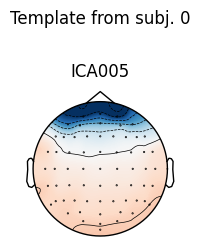

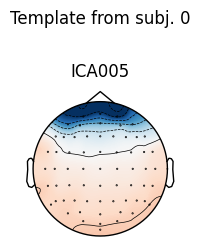

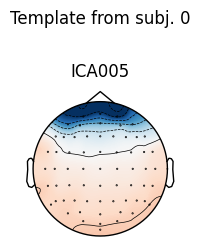

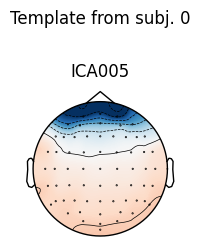

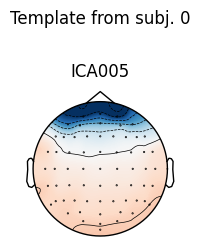

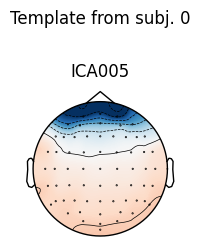

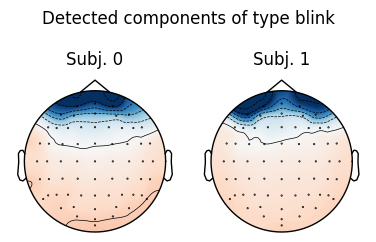

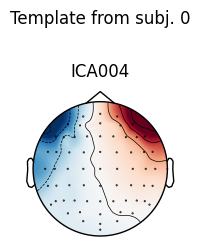

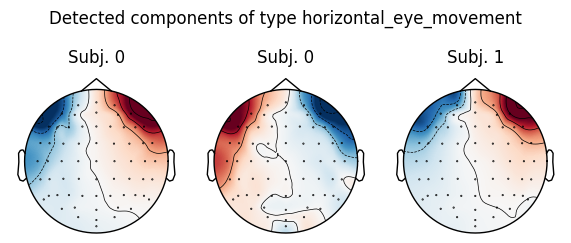

In [5]:
all_dfs = None

ica_epochs_dict = {}
ica_dict = {}
eog_idx_dict = {}
events_dict = {}

for each_file in onlyfiles:
    input_path = data_dir + each_file
    
    sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
    ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]

    if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
    else: sbj = "sbj"+sbj_id
    if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
    else: ssn = "ssn"+ssn_no
    
    if sbj+ssn == "sbj20ssn03":
        ref_ica = None
    else: 
        ref_ica = ica_dict['sbj20ssn03']
    
    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    event_df = event_data_from_data(rns_data)
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0

    # temporary fix for pilot phase where we had some incomplete data
    if 'block_condition' not in event_df:
        event_df['block_condition'] = 'practice'
        event_df.loc[5:,'block_condition'] = 'voice'

    event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                          value=[1, 2, None])

    # ecg
    post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

    # eye
    post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,plot_frequency=20, plot_eye_snippet=40)

    # eeg
    post_processed_event_df, epochs, events, info, reject_log, ica, eog_idx= process_session_eeg(rns_data, post_processed_event_df,
                                run_autoreject=True, run_ica=True, save_raw_eeg = True, raw_eeg_fname = sbj+ssn+"eeg_filt_raw", 
                                template_ica = ref_ica, analyze_pre_ica = True)
    
    # motor
    post_processed_event_df = process_session_motor(rns_data, post_processed_event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)
    
    events_dict[sbj+ssn] = events
    ica_epochs_dict[sbj+ssn] = epochs
    ica_dict[sbj+ssn] = ica
    eog_idx_dict[sbj+ssn] = eog_idx
    
    # save data for later use
    if save_data_pkl:
        
        with open('all_events.pickle', 'wb') as handle_events:
            pickle.dump(events_dict, handle_events, protocol=pickle.HIGHEST_PROTOCOL)
        with open('ica_epochs.pickle', 'wb') as handle_ica_eps:
            pickle.dump(ica_epochs_dict, handle_ica_eps, protocol=pickle.HIGHEST_PROTOCOL)
        with open('ica.pickle', 'wb') as handle_ica:
            pickle.dump(ica_dict, handle_ica, protocol=pickle.HIGHEST_PROTOCOL)
        with open('eog_comp.pickle', 'wb') as handle_eog:
            pickle.dump(eog_idx_dict, handle_eog, protocol=pickle.HIGHEST_PROTOCOL)

    # save
    post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
    if not type(all_dfs)==pd.core.frame.DataFrame:
        all_dfs = post_processed_event_df
    else:
        all_dfs = pd.concat([all_dfs, post_processed_event_df], ignore_index=True)
    

In [6]:
# from pivottablejs import pivot_ui
all_dfs.to_csv(f"{output_dir}all_results.csv")
# all_dfs.to_excel(f"{output_dir}all_results.xlsx")
# pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results.html");

## 2. Load Data and Feature Extraction

In [ ]:
# load raw eeg.fif file and epoch raw eeg

if epoch_raw_eeg:

    with open('all_events.pickle', 'rb') as handle:
        all_events = pickle.load(handle)

    raw_eeg_dir = "saved_files/raw_eeg/"
    event_dict = dict(easy=1, hard=2)

    raw_eeg_dict = {}
    raw_epochs_dict = {}

    for sbj_ssn in list(all_events.keys()):

        each_raw_eeg = sbj_ssn + 'eeg_filt_raw.fif'
        raw_eeg_path = raw_eeg_dir+each_raw_eeg
        raw_eeg = mne.io.read_raw_fif(raw_eeg_path, preload=True)
        raw_eeg_dict[sbj_ssn] = raw_eeg

        epochs_raw = mne.Epochs(raw_eeg, all_events[sbj_ssn], event_id=event_dict, baseline = (None, None), tmin= -3.0, tmax=0, preload=True, on_missing='warn')

        autoreject_epochs = 20
        run_autoreject = True

        if len(epochs_raw) < 10: # we need at least 10 epochs to run autoreject for cross validation
            # bad_epochs_raw = pd.Series(np.full(len(event_df),np.NAN), index=event_df.index, name='autorejected')
            # event_df = event_df.join(bad_epochs)
            reject_log = None
        elif run_autoreject:
            ar_raw = autoreject.AutoReject(random_state=11,n_jobs=1, verbose=False)
            ar_raw.fit(epochs_raw[:autoreject_epochs])  # fit on a few epochs to save time
            epochs_ar, reject_log = ar_raw.transform(epochs_raw, return_log=True)
            # bad_epochs = pd.Series(reject_log.bad_epochs, index=event_recognized_df.index, dtype=bool, name='autorejected')
            # event_df = event_df.join(bad_epochs_raw) # creates nan if not processed at all
            epochs_raw = epochs_ar

        raw_epochs_dict[sbj_ssn] = epochs_raw

    with open('raw_epochs.pickle', 'wb') as handle_raw_eps:
        pickle.dump(raw_epochs_dict, handle_raw_eps, protocol=pickle.HIGHEST_PROTOCOL)
    with open('raw_eeg.pickle', 'wb') as handle_raw_eeg:
        pickle.dump(raw_eeg_dict, handle_raw_eeg, protocol=pickle.HIGHEST_PROTOCOL)


In [7]:
all_dfs = pd.read_csv("output/all_results.csv")

# open saved pickle files
with open('ica_epochs.pickle', 'rb') as handle:
    all_proc_epochs = pickle.load(handle)
with open('ica.pickle', 'rb') as handle:
    all_ica = pickle.load(handle)
with open('eog_comp.pickle', 'rb') as handle:
    all_eog_comps = pickle.load(handle)
with open('raw_epochs.pickle', 'rb') as handle:
    all_raw_epochs = pickle.load(handle)

# save ICA components plot
if save_ica_plts:
    ica_comp_dir = "saved_files/ica_comps/"
    if not os.path.isdir(ica_comp_dir): os.makedirs(ica_comp_dir)

    for sbj_ssn in list(all_ica.keys()):
        
        all_ica[sbj_ssn].plot_components(picks = list(range(0,20)), title=sbj_ssn+"_ICA_Components", show=False)

        plt.savefig(f"{ica_comp_dir}{sbj_ssn}_ica_comps.png")
        plt.close()

In [8]:
# Concatenating all epochs
raw_epochs_concat = mne.concatenate_epochs(list(all_raw_epochs.values()))
proc_epochs_concat = mne.concatenate_epochs(list(all_proc_epochs.values()))

# get EEG data and labels from concatenated epoch objects
raw_epochs_eeg = raw_epochs_concat.get_data()
proc_epochs_eeg = proc_epochs_concat.get_data()

raw_labels = raw_epochs_concat.events[:,2]
proc_labels = proc_epochs_concat.events[:,2]

Not setting metadata
841 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
891 matching events found
Applying baseline correction (mode: mean)


### EEG Feature Extraction

In [10]:
all_dfs_cleaned_up = all_dfs.copy()
all_dfs_cleaned_up = clean_up_adadrive_trials(all_dfs_cleaned_up)

In [32]:
def eeg_features(all_data, data_type):
    
    if data_type == 'processed':
        first_electrode_column_name = "Fp1_4-8_Hz_Power"
        last_electrode_column_name = "O2_32-55_Hz_Power"
        autoreject_column_name = "autorejected"
    elif data_type == 'raw':
        first_electrode_column_name = "Fp1_4-8_Hz_Power_raw"
        last_electrode_column_name = "O2_32-55_Hz_Power_raw"
        autoreject_column_name = "autorejected_raw"
        
    first_electrode_idx = all_data.columns.get_loc(first_electrode_column_name)
    last_electrode_idx = all_data.columns.get_loc(last_electrode_column_name)

    left_pupil_diameter_idx = all_data.columns.get_loc("Left Pupil Diameter")
    right_pupil_diameter_idx = all_data.columns.get_loc("Right Pupil Diameter")

    valid_trial = (all_data['spoken_difficulty_encoded'].notnull()) & (all_data[autoreject_column_name] == False)
    
    all_band_power = all_data.iloc[:,first_electrode_idx:last_electrode_idx+1] # all freq band power in cleaned up data
    pupil_diameter = all_data.iloc[:,left_pupil_diameter_idx:right_pupil_diameter_idx+1]

    data_features = np.asarray(all_band_power.join(pupil_diameter)[valid_trial])
    data_labels = np.asarray(all_data[valid_trial]['spoken_difficulty_encoded'])

    # select only particular channel AF4, F6, F4, AF8, AF7, AF3, F5, F3, FC2, FC4,FC1, FC3, PO4, P4, P6, P3,P5, PO3
    selected_channel_bp = all_band_power.loc[:,
                            all_band_power.columns.str.contains('AF4|F6|F4|AF8|AF3|F5|F3|AF7|FC2|FC4|FC4|FC1|FC3|PO4|P4|P6|P3|P5|PO3')]
    selected_data_features=np.asarray(selected_channel_bp.join(pupil_diameter)[valid_trial])
    selected_data_labels=np.asarray(all_dfs_cleaned_up[valid_trial]['spoken_difficulty_encoded'])
    
    return selected_data_features, selected_data_labels

In [45]:
raw_selected_data_features, raw_selected_data_labels = eeg_features(all_dfs_cleaned_up, 'raw')
processed_selected_data_features, processed_selected_data_labels = eeg_features(all_dfs_cleaned_up, 'processed')

### Features Concatenation and Normalization

In [49]:
raw_feature = raw_selected_data_features
proc_feature = processed_selected_data_features

if sum(sum(np.isnan(raw_feature))) > 0 or sum(sum(np.isnan(proc_feature))) > 0:
    
    invalid_pupil_proc = np.argwhere(np.any(np.isnan(proc_feature) == True, axis=1))
    proc_feature_corrected = np.delete(proc_feature, invalid_pupil_proc, axis=0)
    proc_labels_corrected = np.delete(processed_selected_data_labels, invalid_pupil_proc, axis=0)
    
    invalid_pupil_raw = np.argwhere(np.any(np.isnan(raw_feature) == True, axis=1))
    raw_feature_corrected = np.delete(raw_feature, invalid_pupil_raw, axis=0)
    raw_labels_corrected = np.delete(raw_selected_data_labels, invalid_pupil_raw, axis=0)
    
else:
    raw_feature_corrected = raw_feature
    raw_labels_corrected = raw_selected_data_labels
    proc_feature_corrected = proc_feature
    proc_labels_corrected = processed_selected_data_labels

# print(raw_feature_corrected.shape,raw_labels_corrected.shape, proc_feature_corrected.shape, proc_labels_corrected.shape)
    
# Data Split
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(raw_feature_corrected, raw_labels_corrected, random_state=rs)
x_train_proc, x_test_proc, y_train_proc, y_test_proc = train_test_split(proc_feature_corrected, proc_labels_corrected, random_state=rs)

# fit scaler on training data (fitting scaler on ONLY training data prevent data leakage)
norm_raw = MinMaxScaler().fit(x_train_raw)
norm_proc = MinMaxScaler().fit(x_train_proc)

# Normalize training and testing data 
raw_train_norm = norm_raw.transform(x_train_raw)
raw_test_norm = norm_raw.transform(x_test_raw)
proc_train_norm = norm_proc.transform(x_train_proc)
proc_test_norm = norm_proc.transform(x_test_proc)

## 3. Trial Difficulty Classification

In [56]:
# Trial Difficulty Classification Function
def spoken_difficulty_classification(train_data, test_data, train_label, test_label, method, data_type = None):

    if method == 'logistic':

        logreg = LogisticRegression(solver="liblinear", penalty = 'l2', random_state=0).fit(train_data, train_label)
        score_train = logreg.decision_function(train_data)
        score_test = logreg.decision_function(test_data)

        train_pred = logreg.predict(train_data)
        test_pred = logreg.predict(test_data)
        
        importance = logreg.coef_[0]

    if method == 'svm':

        svm_classifer = SGDClassifier(random_state=0).fit(train_data, train_label)
        score_train = svm_classifer.decision_function(train_data)
        score_test = svm_classifer.decision_function(test_data)

        train_pred = svm_classifer.predict(train_data)
        test_pred = svm_classifer.predict(test_data)
        
        importance = svm_classifer.coef_[0]

    if method == 'knn':
        kNN = KNeighborsClassifier(n_neighbors = 3).fit(train_data, train_label)

        score_train = kNN.predict_proba(train_data)[:,1]
        score_test = kNN.predict_proba(test_data)[:,1]

        train_pred = (score_train > 0.5) + 0
        test_pred = (score_test >0.5) + 0

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_label-1, score_train)
    ROC_score_train = metrics.roc_auc_score (train_label-1, score_train)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test_label-1, score_test)
    ROC_score_test = metrics.roc_auc_score (test_label-1, score_test)

    train_acc = metrics.accuracy_score(train_label,train_pred)
    test_acc = metrics.accuracy_score(test_label,test_pred)

    # ROC Curve
    sns.set(font_scale=2)
    plt.style.use('seaborn-white')
    fig = plt.figure(figsize = [25,7])

    axe = fig.add_subplot(1,2,1)
    axe.plot(fpr_train,tpr_train)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Training ROC Curve")
    axe.text(0.6,0.2,"AUC = {:.2f}".format(ROC_score_train))

    axe = fig.add_subplot(1,2,2)
    axe.plot(fpr_test,tpr_test)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Testing ROC Curve")
    axe.text(0.6,0.2,"AUC = {:.2f}".format(ROC_score_test))
    
    plt.savefig(f"{data_type}_data_Training_Testing_ROC_Curve.png", dpi=300)

    # plt.grid(visible=False)
    
    # Confusion Matrix
    # fig, (ax1, ax2) = plt.subplots(1,2)
    
    fig_cnf = plt.figure(figsize = [20, 5])
    ax1 = fig_cnf.add_subplot(1,2,1)
    ax2 = fig_cnf.add_subplot(1,2,2)

    cnf_matrix_train = metrics.confusion_matrix(train_label, train_pred)
    cnf_matrix_test = metrics.confusion_matrix(test_label, test_pred)
    
    sns.heatmap(cnf_matrix_train, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax1)
    ax1.set_title("Training Confusion Matrix")
    sns.heatmap(cnf_matrix_test, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax2)
    ax2.set_title("Testing Confusion Matrix")
    
    plt.savefig(f"{data_type}_data_Training_Testing_Confusion_Matrix.png", dpi=300)
    
    # Features Importance
    if method is 'logistic' or method is 'svm':
        fig_importance = plt.figure(figsize = [10 ,3])
        axe = fig_importance.add_subplot(1,1,1)
        
        axe.bar([x for x in range(len(importance))], importance)
        axe.set_xlabel("Feature")
        axe.set_ylabel("Importance/Coefficient")
        axe.set_title("Coefficient for Each Features")
        plt.savefig(f"{data_type}_data_coefficient.png")
    
    plt.show()
    
    return test_pred, train_pred, train_acc, test_acc

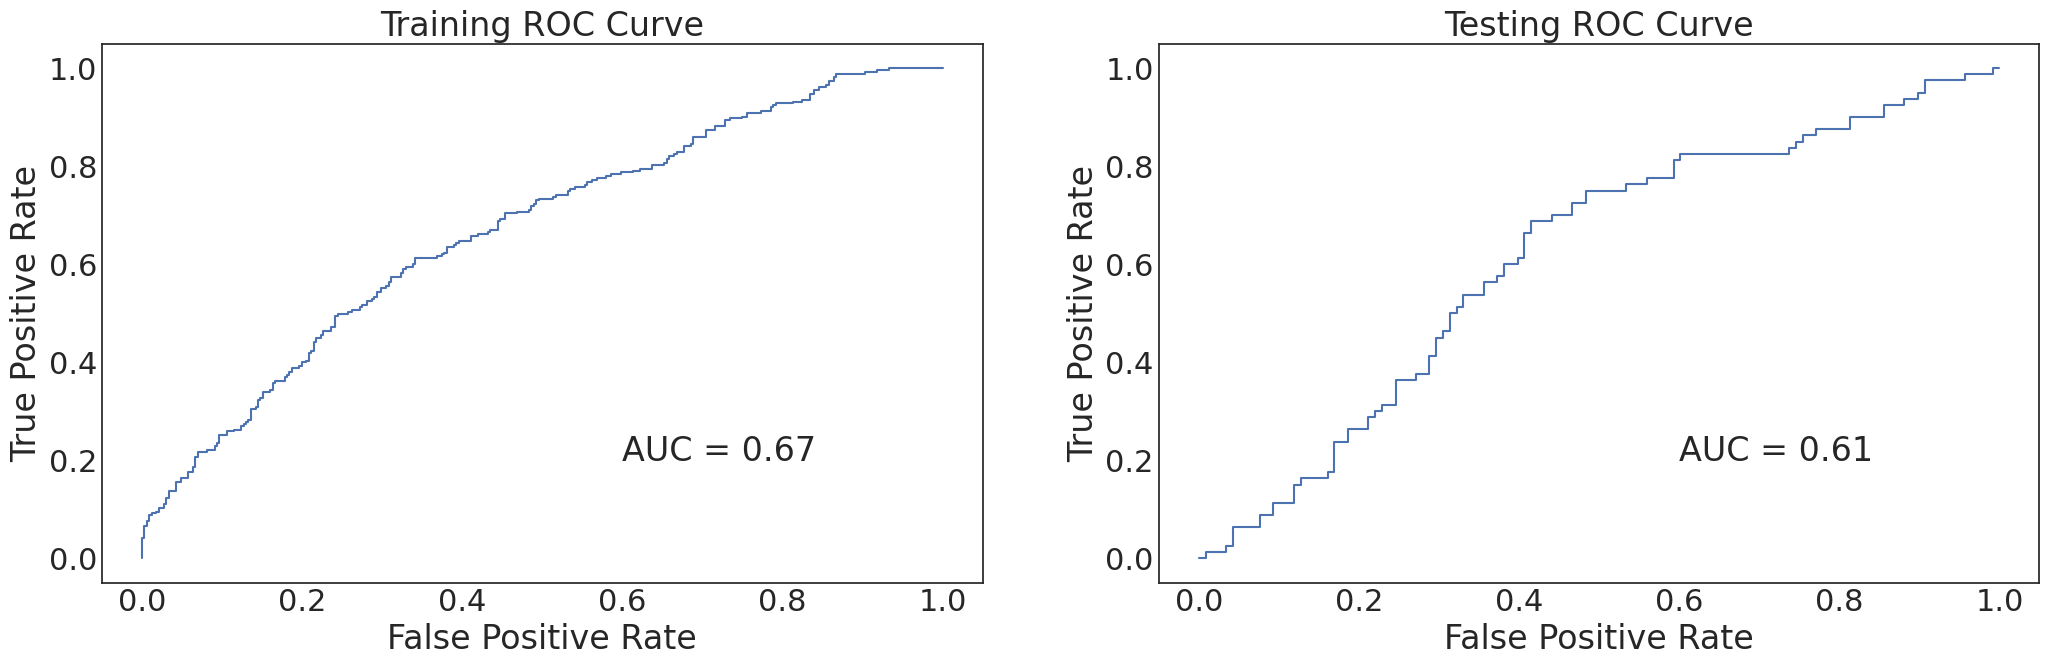

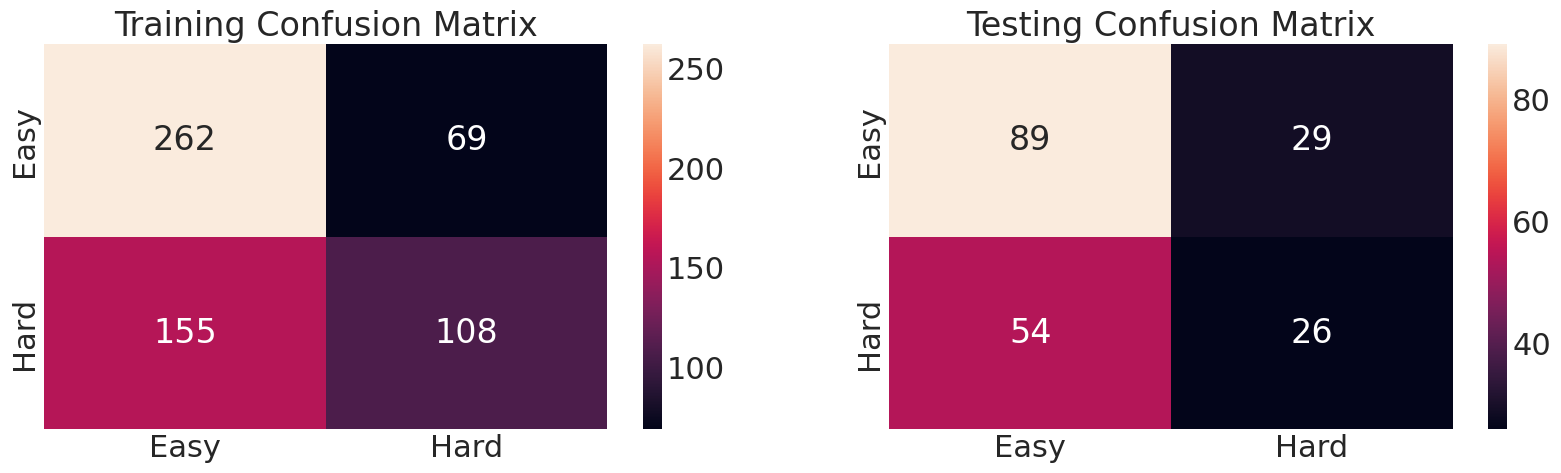

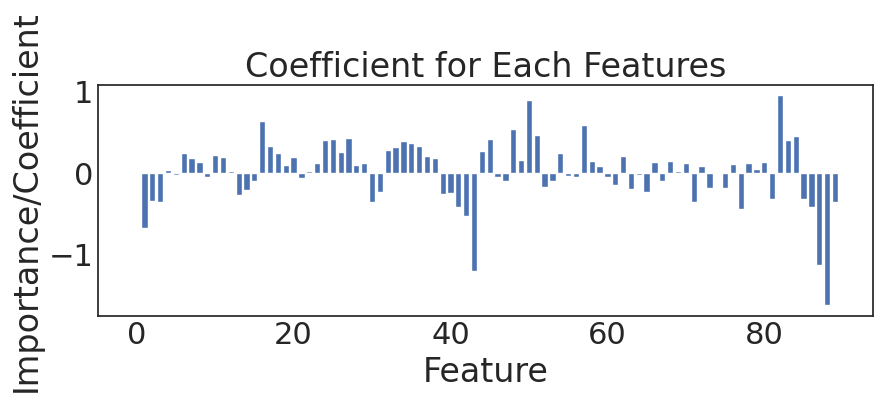

In [62]:
# Trial Difficulty Classification - Raw EEG 
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw = spoken_difficulty_classification(raw_train_norm, raw_test_norm,y_train_raw, y_test_raw, 'logistic', 'raw')

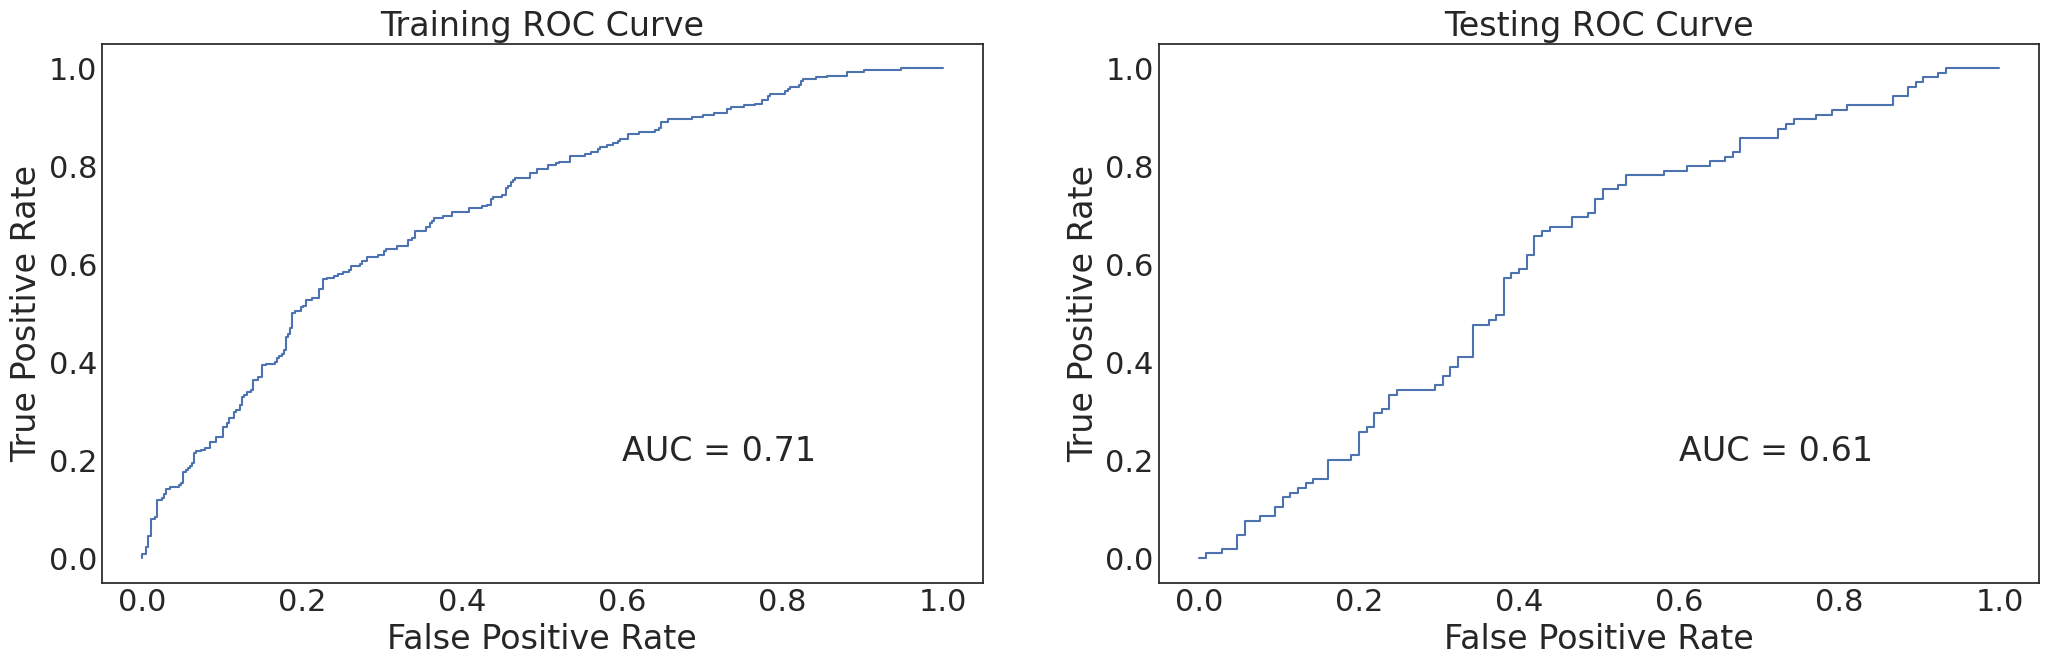

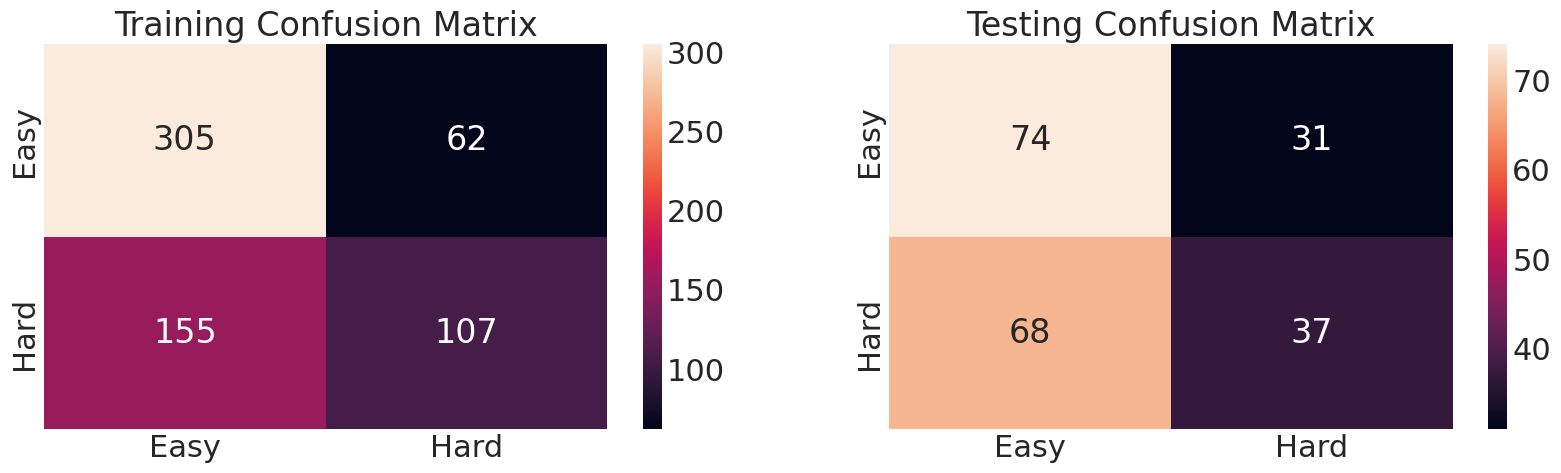

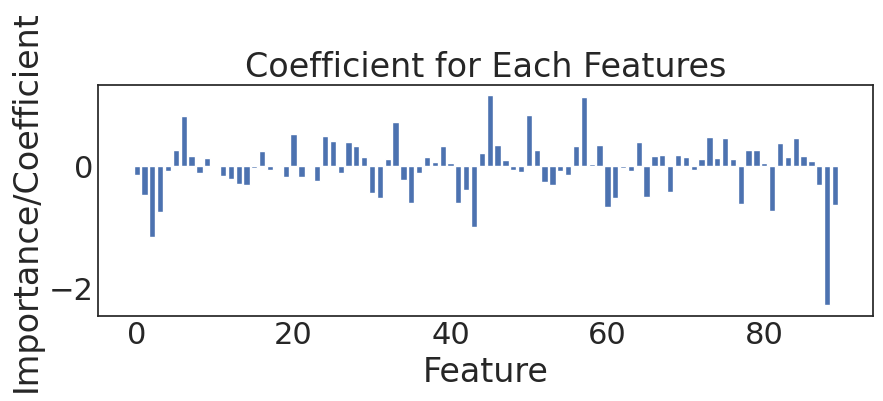

In [61]:
# Trial Difficulty Classification - Artifacts Removed EEG

test_pred_proc, train_pred_proc, train_acc_proc, test_acc_proc = spoken_difficulty_classification(proc_train_norm, proc_test_norm,y_train_proc, y_test_proc, 'logistic', 'processed')

# print(f"Training Accuracy with Artifacts Removal: {train_acc_proc:.2f} \n"
#       f"Training Label:      {y_train_proc} \n"
#       f"Training Prediction: {train_pred_proc} \n"
#       f"Test Accuracy with Artifacts Removal: {test_acc_proc:.2f} \n"
#       f"Test Label:      {y_test_proc} \n"
#       f"Test Prediction: {test_pred_proc}")

## ICA-Adaptive Filter - WIP

In [66]:
# !pip install EMD_signal
import PyEMD
from PyEMD import EMD, Visualisation

# eeg_comps = ica.get_sources(raw).get_data() #eeg componenets for all epochs
# # eeg_comps = ica.get_sources(epochs).get_data() #eeg componenets for all epochs
# # comps_epoch_concat = np.empty([eeg_comps.shape[1],eeg_comps.shape[2]*eeg_comps.shape[0]]) #initiate empty array
# # for i in range(eeg_comps.shape[0]):
# #     comps_epoch_concat[:,i*eeg_comps.shape[2]:eeg_comps.shape[2]*(i+1)] = eeg_comps[i]

# component_no = 5
# test_comps = eeg_comps[component_no]

# emd = EMD() # EMD instantiation
# emd.emd(test_comps) # decompose signal into IMFs and residue
# imfs, res = emd.get_imfs_and_residue()

# # # imfs = emd(np.squeeze(eeg_comps[0])[0])

In [ ]:
# scipy.stats.kurtosis(test_comps)

In [ ]:
# # Visualization
# t = np.arange(0, 3+1/freq, 1/freq)
# vis = Visualisation()
# vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
# # vis.plot_instant_freq(t, imfs=imfs)
# vis.show()